- srun --time=10:00:00 --gres=gpu:1 --pty bash
- nvidia-smi

In [1]:
import sys
print(sys.executable)

/array/shared/home/mricard/.venv/venvPFE/bin/python


In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.5.1+cu124
12.4
False


In [20]:
import numpy as np
import pandas as pd
import scipy.ndimage

## Generate datas

First we need to generate the data corresponding to these keys: 'geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'sim_time'.

These keys have dimensions (37, 256, 128). 37 corresponds to the pressure level in the atmosphere and (256, 128) corresponds to the coordinates on the earth. 256 is a simplified dimension for longitude and 128 is a simplified dimension for latitude.

We're going to generate data on a simplified model by reducing the dimension by around 8. We therefore have this dimension for our simplified model: (5, 32, 16)

For example, for the ‘geopotential’ key, we will generate data based on the density of these 5 pressure levels:

Level :  0
- Mean : 465315
- Standard deviation : 14729
- Min Value : 427966
- Max Value : 482014


Level :  8
- Mean : 199837
- Standard deviation : 5439
- Min Value : 183852
- Max Value : 204361


Level :  16
- Mean : 101209
- Standard deviation : 5618
- Min Value : 90911
- Max Value : 108308


Level :  24
- Mean : 34489
- Standard deviation : 2438
- Min Value : 28310
- Max Value : 37926


Level :  32
- Mean : 9146
- Standard deviation : 1322
- Min Value : 3201
- Max Value : 11682

In [21]:
levels = [
    {"mean": 465315, "std": 14729, "min": 427966, "max": 482014},
    {"mean": 199837, "std": 5439, "min": 183852, "max": 204361},
    {"mean": 101209, "std": 5618, "min": 90911, "max": 108308},
    {"mean": 34489,  "std": 2438, "min": 28310, "max": 37926},
    {"mean": 9146,   "std": 1322, "min": 3201, "max": 11682}
]

generated_geopotential = torch.empty((5, 32, 16))

for i, level in enumerate(levels):
    data = torch.normal(mean=level["mean"], std=level["std"], size=(32, 16)).numpy()
    data = scipy.ndimage.gaussian_filter(data, sigma=2)
    data = np.clip(data, level["min"], level["max"])
    generated_geopotential[i] = torch.tensor(data)

generated_geopotential.shape


torch.Size([5, 32, 16])

In [22]:
levels = [
    {'mean': 3.8344e-06, 'std': 1.564e-07, 'min': 3.0758e-06, 'max': 4.0835e-06},
    {'mean': 2.818e-06, 'std': 8.4e-08, 'min': 2.5599e-06, 'max': 3.2926e-06},
    {'mean': 6.09523e-05,'std': 8.11908e-05,'min': 3.2823e-06,'max': 0.0004949116},
    {'mean': 0.0018833724,'std': 0.0021755043,'min': 1.4893e-05,'max': 0.010320779},
    {'mean': 0.005408603,'std': 0.0049265353,'min': 6.23738e-05,'max': 0.017578755}
    ]

generated_specific_humidity = torch.empty((5, 32, 16))

for i, level in enumerate(levels):
    data = torch.normal(mean=level["mean"], std=level["std"], size=(32, 16)).numpy()
    data = scipy.ndimage.gaussian_filter(data, sigma=2)
    data = np.clip(data, level["min"], level["max"])
    generated_specific_humidity[i] = torch.tensor(data)

generated_specific_humidity.shape

torch.Size([5, 32, 16])

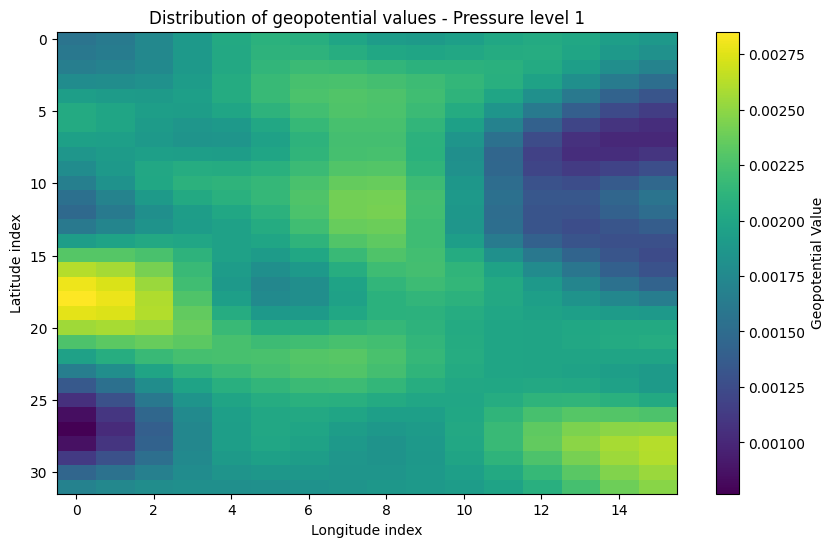

In [23]:
import matplotlib.pyplot as plt

level_1_data = generated_specific_humidity[3]

plt.figure(figsize=(10, 6))
plt.imshow(level_1_data, cmap='viridis', aspect='auto')
plt.colorbar(label="Geopotential Value")
plt.title("Distribution of geopotential values - Pressure level 1")
plt.xlabel("Longitude index")
plt.ylabel("Latitude index")
plt.show()

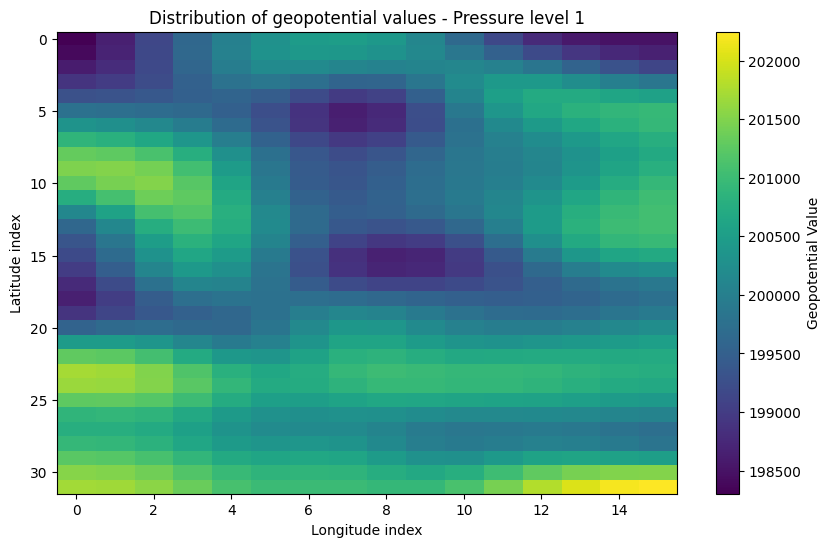

In [24]:
import matplotlib.pyplot as plt

level_1_data = generated_geopotential[1] 

plt.figure(figsize=(10, 6))
plt.imshow(level_1_data, cmap='viridis', aspect='auto')
plt.colorbar(label="Geopotential Value")
plt.title("Distribution of geopotential values - Pressure level 1")
plt.xlabel("Longitude index")
plt.ylabel("Latitude index")
plt.show()

We have chosen to focus first on 2D data, and will therefore only consider the first layer of the atmosphere.

In [25]:
data = torch.stack([generated_geopotential[0], generated_specific_humidity[0]], dim=0)
data.shape

torch.Size([2, 32, 16])

First of all, we normalise the data in order to obtain reduced centred data.

In [26]:
mean_geo = data[0].mean()
std_geo  = data[0].std()

mean_hum = data[1].mean()
std_hum  = data[1].std()

data[0] = (data[0] - mean_geo)/std_geo
data[1] = (data[1] - mean_hum)/std_hum

data

tensor([[[-1.6718, -1.4960, -1.1328,  ...,  1.3631,  0.7897,  0.4547],
         [-1.3551, -1.2554, -0.9917,  ...,  1.0958,  0.4520,  0.0850],
         [-0.9518, -0.9488, -0.8157,  ...,  0.6603, -0.0701, -0.4764],
         ...,
         [ 0.3445,  0.3511,  0.2565,  ..., -0.9258, -0.9182, -0.8996],
         [ 0.9333,  0.8583,  0.6426,  ..., -0.6888, -0.7284, -0.7155],
         [ 1.2868,  1.1623,  0.8804,  ..., -0.6310, -0.7274, -0.7318]],

        [[ 1.9591,  1.1366,  0.0735,  ...,  0.9054,  0.8345,  0.8551],
         [ 2.0699,  1.3476,  0.3933,  ...,  0.5525,  0.4266,  0.4089],
         [ 2.2532,  1.6699,  0.8533,  ...,  0.1343, -0.0594, -0.1284],
         ...,
         [ 2.0783,  1.5709,  0.8714,  ...,  1.9949,  2.1280,  2.2319],
         [ 2.2517,  1.6752,  0.8466,  ...,  2.0084,  1.9155,  1.8853],
         [ 2.2493,  1.6461,  0.7613,  ...,  1.9842,  1.7645,  1.6643]]])

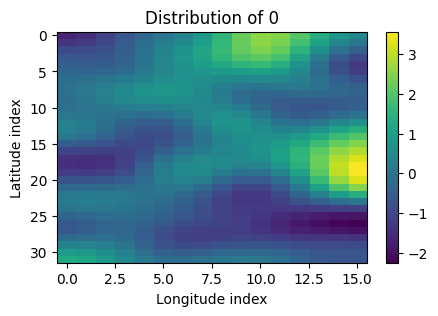

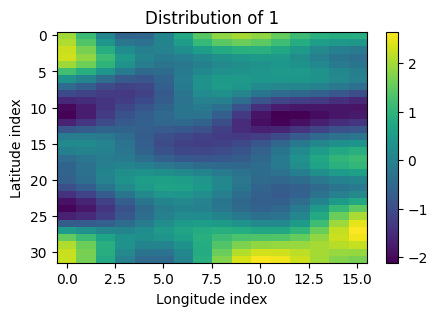

In [27]:
for i in range(2) :
    plt.figure(figsize=(5, 3))
    plt.imshow(data[i], cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Distribution of {i}")
    plt.xlabel("Longitude index")
    plt.ylabel("Latitude index")
    plt.show()

And we do so for all the other features.

The normalised data is then transferred to encoder (Lounis)

For the learned physics module, we gonna first generate random data.

In [31]:
pressure = torch.empty((5, 32, 16))

for i in range(pressure.shape[0]):
    data = torch.normal(mean=0, std=1, size=(32, 16)).numpy()
    data = scipy.ndimage.gaussian_filter(data, sigma=2)
    pressure[i] = torch.tensor(data)

pressure.shape

torch.Size([5, 32, 16])

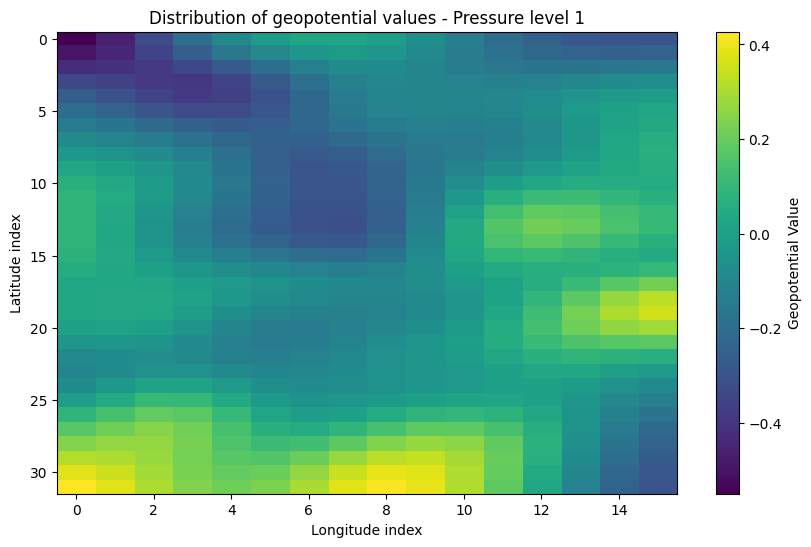

In [32]:
level_1_data = pressure[3]

plt.figure(figsize=(10, 6))
plt.imshow(level_1_data, cmap='viridis', aspect='auto')
plt.colorbar(label="Geopotential Value")
plt.title("Distribution of geopotential values - Pressure level 1")
plt.xlabel("Longitude index")
plt.ylabel("Latitude index")
plt.show()

First, we need to concatenate the data into 1D layers.

In [ ]:
data = data.view(2, -1)
data.shape

torch.Size([2, 512])

In [ ]:
import torch.nn as nn

class VerticalEmbeddingNetwork(nn.Module):
    def __init__(self):
        super(VerticalEmbeddingNetwork, self).__init__()
        
        #we code the convolution network describe in the paper
        self.net = nn.Sequential(
            nn.Conv1d(in_channels = 2, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
            )
        
    def forward(self, x) :
        x = self.net(x)
        return x

model_VEN = VerticalEmbeddingNetwork()
output_VEN = model_VEN(data)
output_VEN.shape

torch.Size([32, 512])

In [ ]:
import torch
import torch.nn as nn

class ProcessBlock(nn.Module):
    def __init__(self, latent_dim=384):
        super(ProcessBlock, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim), 
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim) 
        )
        
        self.norm = nn.LayerNorm(latent_dim)

    def forward(self, x):
        out = self.mlp(x)
        out = self.norm(out + x) 
        return out


latent_vector = torch.rand(10, 384)
process_block = ProcessBlock(latent_dim=384)
output = process_block(latent_vector)

print("Taille de sortie :", output.shape)


Taille de sortie : torch.Size([10, 384])
